# The Oerlemans & Nick frontal ablation parameterization in OGGM

<div class="alert alert-info">
    <b>
        The calving parameterization in OGGM has been developped for versions of OGGM before 1.6 (mostly: 1.5.3). The v1.6 series brought several changes in the mass balance calibration which made a lot of the calibration code obsolete and in need of updates.As of today (August 2024), calving dynamics are implemented in the dynamical model and they "work", as illustrated below. However, there is still quite some work to make calving (including calibration) fully operational for large scale runs.</b><br>See <a href="https://github.com/OGGM/oggm/issues/1733">this github issue</a> for a longer discussion.
</div>

We implement the simple frontal ablation parameterization of [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) in OGGM's flowline model:

$$F_{calving} = k d H_f w$$

With $H_f$, $d$ and $w$ the ice thickness, the water depth and the glacier width at the calving front, $F_{calving}$ the calving flux in units m$^3$ yr$^{-1}$ and $k$ a scaling parameter that needs to be calibrated (units: yr$^{-1}$). Another way to see at this equation is to note that the frontal calving rate $\frac{F_{Calving}}{H_f w}$ (m yr$^{-1}$) is simply the water depth scaled by the $k$ parameter.

[Malles et al., 2023](https://doi.org/10.1017/jog.2023.19) introduces some changes to the physics and numerics of calving. We illustrate both models below.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import time, os

from oggm.core.massbalance import ScalarMassBalance
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.tests.funcs import bu_tidewater_bed
from oggm.core.flowline import FluxBasedModel

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False

## FluxBasedModel "default" implementation

The implementation in OGGM's flowline model was relatively straightforward but required some tricks. You can have a look at the code [here](https://github.com/OGGM/oggm/blob/b5934589466bc5245303ce762572f2df8cf92369/oggm/core/flowline.py#L1322-L1379), but in short:
- the terminus thickness $H_f$ is defined as the last grid point on the calving flowline with its surface elevation **above the water level**. That is, if small chunks of ice after that are below water, their thickness is not used for the calving equation.
- the calving flux computed with the equation above is added to a "bucket". This bucket can be understood as "ice that has calved but has not yet been removed from the flowline geometry". We remove this bucket from the total flowline volume when computing model output, though.
- when there is ice below water (e.g. due to ice deformation at the front) and the bucket is large enough, remove it and subtract its volume from the bucket.
- if, after that, the bucket is larger than the total volume of the last flowline grid point above water (the calving front), remove the calving front (calve it) and subtract its volume from the bucket.

To avoid numerical difficulties, we introduce a "flux limiter" at the glacier terminus. The slope between the last grid point above water (the calving front) and the next grid point (often: the sea bed) is cropped to a maximum threshold (per default: the difference between the calving front altitude and the water level) in order to limit ice deformation. See the example below for details.

### Idealized experiments 

We use the idealized bed profile from [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) and [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160). This profile has a deepening followed by a bump, allowing to study quite interesting water-depth – calving-rate feedbacks:

In [ ]:
bu_fl = bu_tidewater_bed()[0]

xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xc, bu_fl.bed_h, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

We create a simple experiment where the surface mass-balance is zero in the entire domain. Ice enters via a flux gate on the left (unit: m$^{3}$ s$^{-1}$). We can vary the amount of ice entering the domain via the flux gate. We let the glacier grow until equilibrium with three different flux values:

In [ ]:
mb_model = ScalarMassBalance()

to_plot = None
keys = []
for flux_gate in [0.06, 0.10, 0.16]:
    model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                           is_tidewater=True, 
                           flux_gate=flux_gate,  # default is 0
                           calving_k=0.2,  # default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium 
    ds = model.run_until_and_store(6000)
    df_diag = model.get_diagnostics()
    
    if to_plot is None:
        to_plot = df_diag
    
    key = 'Flux gate={:.02f}. Calving rate: {:.0f} m yr-1'.format(flux_gate, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
to_plot.index = xc

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

The larger the incoming ice flux, the bigger and longer the glacier. If the flux is large enough, the glacier will grow past the deepening and the bump, until the water depth and the calving rate become large enough to compensate for the total ice entering the domain.

### Flux limiter 

The frontal "free board" (the height of the ice above water at the terminus) is quite high in the plot above. This is because we use a "flux limiter", effectively reducing the shear stress at the steep glacier front and avoiding high velocities, simplifying the numerics. This limiter is of course arbitrary and non-physical, but we still recommend to switch it on for your runs. Here we show the differences between two runs (with and without flux limiter):

In [ ]:
to_plot = None
keys = []
for limiter in [True, False]:
    model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                           is_tidewater=True, 
                           calving_use_limiter=limiter,  # default is True
                           flux_gate=0.06,  # default is 0
                           calving_k=0.2,  # default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium 
    ds = model.run_until_and_store(7000)
    df_diag = model.get_diagnostics()
    
    if to_plot is None:
        to_plot = df_diag
    
    key = 'Flux limiter={}. Calving rate: {:.0f} m yr-1'.format(limiter, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
to_plot.index = xc

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

For the rest of this notebook, we will keep the flux limiter **on**. It is also switched on per default in OGGM.

In [ ]:
# see
cfg.PARAMS['calving_use_limiter']

### Water-depth – calving-rate feedbacks

Let's have some fun! We apply a periodic forcing to our glacier and study the advance and retreat of our glacier (the simulation below can take a couple minutes to run).

In [ ]:
years = np.arange(6001)
flux = 0.4 + 0.4 * np.sin(2 * np.pi * years / 5000)
def flux_gate(year):
    return flux[int(year)]

In [ ]:
model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                       is_tidewater=True, 
                       glen_a=cfg.PARAMS['glen_a']*3, # make the glacier flow faster
                       flux_gate=flux_gate,  # default is 0
                       calving_k=1,  # default is 2.4
                       do_kcalving=True
                      )
t0 = time.time()
ds = model.run_until_and_store(len(flux)-1)
print('Done! Time needed: {}s'.format(int(time.time()-t0)))

In [ ]:
# Prepare the data for plotting
df = (ds.volume_m3 * 1e-9).to_dataframe(name='Volume [km$^3$]')[['Volume [km$^3$]']]
df['Length [m]'] = (ds['length_m'] / 1000).to_series()
df['Calving rate [m y$^{-1}$]'] = ds['calving_rate_myr'].to_series()
df['Forcing'] = flux

# Thresholds
deep_val = 27
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index < 5000)]
deep_t0, deep_t1 = dfs.index[0], dfs.index[-1]
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index > 5000)]
deep_t2 = dfs.index[0]

bump_val = 37.5
dfs = df.loc[(df['Length [m]'] >= bump_val) & (df.index < 5000)]
bump_t0, bump_t1 = dfs.index[0], dfs.index[-1]

In [ ]:
# The plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
ts = df['Forcing']
ts.plot(ax=ax1, color='C0');
ax1.set_ylabel(ts.name)
ts = df['Length [m]']
ts.plot(ax=ax2, color='C1');
ax2.hlines(deep_val, deep_t0, deep_t1, color='black', linestyles=':')
ax2.hlines(deep_val, deep_t2, 6000, color='black', linestyles=':')
ax2.hlines(bump_val, bump_t0, bump_t1, color='grey', linestyles='--')
ax2.annotate('Deepening', (deep_t0, deep_val-5))
ax2.annotate('Bump', (bump_t0, bump_val-5))
ax2.set_ylabel(ts.name)
# The calving rate is a bit noisy because of the bucket trick - we smooth
ts = df['Calving rate [m y$^{-1}$]'].rolling(11, center=True).max()
ts.plot(ax=ax3, color='C3')
ax3.vlines([deep_t0, deep_t1, deep_t2], ts.min(), ts.max(), color='black', linestyles=':')
ax3.vlines([bump_t0, bump_t1], ts.min(), ts.max(), color='grey', linestyles='--');
ax3.set_ylabel(ts.name); ax3.set_xlabel('Years');

Our simple model reproduces the results of [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) and [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160) qualitatively (with the models and model parameters being different, an exact comparison is difficult). For example, here is Fig. 8 from [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160):

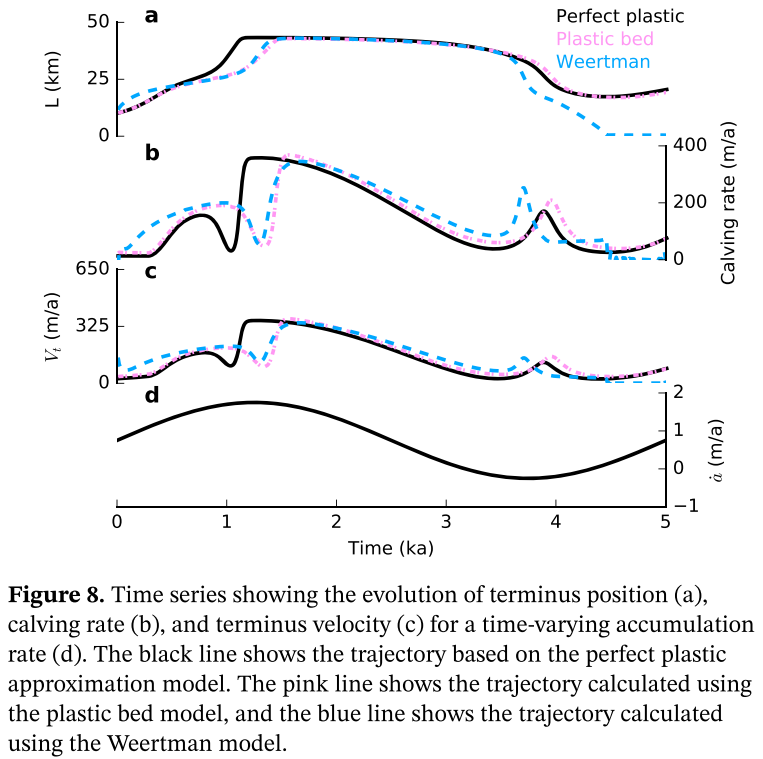

## Same experiments, but with the new implementation

[Malles et al., 2023](https://doi.org/10.1017/jog.2023.19) uses the same equation but makes substantial changes to some of the physics. In a nutshell:
- backpressure from the water is implemented, making physics more realistic and removing the need for the flux limiter
- sliding is increased when below water
- some other logics and checks that where needed to make calving more realistic in edge cases (this is a large part of the code)

Otherwise it works pretty much like the existing one:

In [ ]:
from oggm.sandbox import calving_jan

In [ ]:
model = calving_jan.CalvingFluxBasedModelJan(bu_tidewater_bed(), mb_model=mb_model,
                                             is_tidewater=True, 
                                             glen_a=cfg.PARAMS['glen_a']*3, # make the glacier flow faster
                                             flux_gate=flux_gate,  # default is 0
                                             calving_k=0.6,  # default is 2.4 - Note the different value for calving here to obtain similar results as above
                                             do_kcalving=True
                                             )
t0 = time.time()
ds_new = model.run_until_and_store(len(flux)-1)
print('Done! Time needed: {}s'.format(int(time.time()-t0)))

First observation is that its slower by a factor at least two. Let's have a look at the results:

In [ ]:
# Prepare the data for plotting
df = (ds.volume_m3 * 1e-9).to_dataframe(name='Volume [km$^3$]')[['Volume [km$^3$]']]
df['Length [m]'] = (ds_new['length_m'] / 1000).to_series()
df['Calving rate [m y$^{-1}$]'] = ds_new['calving_rate_myr'].to_series()
df['Forcing'] = flux

# Thresholds
deep_val = 27
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index < 5000)]
deep_t0, deep_t1 = dfs.index[0], dfs.index[-1]
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index > 5000)]
deep_t2 = dfs.index[0]

bump_val = 37.5
dfs = df.loc[(df['Length [m]'] >= bump_val) & (df.index < 5000)]
bump_t0, bump_t1 = dfs.index[0], dfs.index[-1]

In [ ]:
# The plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
ts = df['Forcing']
ts.plot(ax=ax1, color='C0');
ax1.set_ylabel(ts.name)
ts = df['Length [m]']
ts.plot(ax=ax2, color='C1');
ax2.hlines(deep_val, deep_t0, deep_t1, color='black', linestyles=':')
ax2.hlines(deep_val, deep_t2, 6000, color='black', linestyles=':')
ax2.hlines(bump_val, bump_t0, bump_t1, color='grey', linestyles='--')
ax2.annotate('Deepening', (deep_t0, deep_val-5))
ax2.annotate('Bump', (bump_t0, bump_val-5))
ax2.set_ylabel(ts.name)
# The calving rate is a bit noisy because of the bucket trick - we smooth
ts = df['Calving rate [m y$^{-1}$]'].rolling(11, center=True).max()
ts.plot(ax=ax3, color='C3')
ax3.vlines([deep_t0, deep_t1, deep_t2], ts.min(), ts.max(), color='black', linestyles=':')
ax3.vlines([bump_t0, bump_t1], ts.min(), ts.max(), color='grey', linestyles='--');
ax3.set_ylabel(ts.name); ax3.set_xlabel('Years'); ax3.set_ylim(0, 150);

In [ ]:
ds.length_m.plot();
ds_new.length_m.plot();

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)